In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, random_clifford, Pauli, Operator, partial_trace, entropy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from quantum_simulation_recipe.spin import Nearest_Neighbour_1d
from quantum_simulation_recipe.trotter import *
from quantum_simulation_recipe.bounds import norm, tight_bound, commutator
from quantum_simulation_recipe.plot_config import *
from time import sleep
from tqdm import tqdm

def StateError(state,ErrorU):
    st=ErrorU @ state
    error=np.real(st.conj().T @ st)
    return np.sqrt(error)

States_of_different_magics=np.load("./data/differentstates.npy")
Magics=np.load("./data/differentmagics_right.npy")

ModuleNotFoundError: No module named 'lattice_hamiltonians'

In [11]:
# Model: 1D Heisenberg model
n=10
J,h=1,0.2
t=10
r=100
delta_t=t/r
order=1
hnn=Nearest_Neighbour_1d(n=n,Jx=J,Jy=J,Jz=J,hx=h,hy=0,hz=0,pbc=True)
h_list=hnn.ham_xyz
approx_U=pf(h_list,t=delta_t,r=1,order=1)
exact_U=expH(hnn.ham,delta_t)
Error_U=exact_U-approx_U

#Distribution of errors for different magics
SampleScale=1
Errors=np.load("./OtherHamiltonians/5qubitsHeisenbergGCdistribution.npy").tolist()
generate_or_not=True
if(generate_or_not):
    Update_errors=[]
    j=0
    for i,st in enumerate(States_of_different_magics):
        if i in [0,1,2,4,8]: 
            pbar=tqdm(total=SampleScale)
            step=0
            state=Statevector(st)
            sample=Errors[j]
            while step < SampleScale:
                state=state.evolve(random_clifford(n))
                error=StateError(state.data,Error_U)
                sample.append(error)
                pbar.update(1)
                step+=1  
            pbar.close()
            Update_errors.append(sample)
            j+=1
    print(Update_errors)
    np.save("./OtherHamiltonians/5qubitsHeisenbergGCdistribution.npy",Update_errors)

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

[[0.07517532464956067, 0.07435825625687412, 0.07503682809908215, 0.07382813892743248, 0.07781150890472348, 0.07624125735580561, 0.07666448290740813, 0.07626005332239791, 0.07595767446805532, 0.07546717275204785, 0.07637908359247778, 0.07507874168889768, 0.0754530954278913, 0.07449479471592041, 0.07612860225609867, 0.07867036072853231, 0.07782466142085531, 0.07540112542601045, 0.0758881909449722, 0.07738281638612933, 0.07566664552976143, 0.07402131065605953, 0.07506095903209567, 0.0752347096139042, 0.07462711643441416, 0.07589802366884707, 0.07373454129209055, 0.0763798805557722, 0.07507938826946974, 0.0774730283874329, 0.07427155973432438, 0.07473610436564171, 0.07474515900065638, 0.07694898258195457, 0.0769549897101208, 0.07602326814552893, 0.07401667435333789, 0.07727807924429683, 0.07559362061550813, 0.07529355079108495, 0.07495965452618741, 0.07662842262547269, 0.07736583659716345, 0.07542671975722944, 0.07606639277099822, 0.07798199201656984, 0.07566037069712969, 0.076184474938831

R-squared for kurtosis fit: 0.9273298904774263


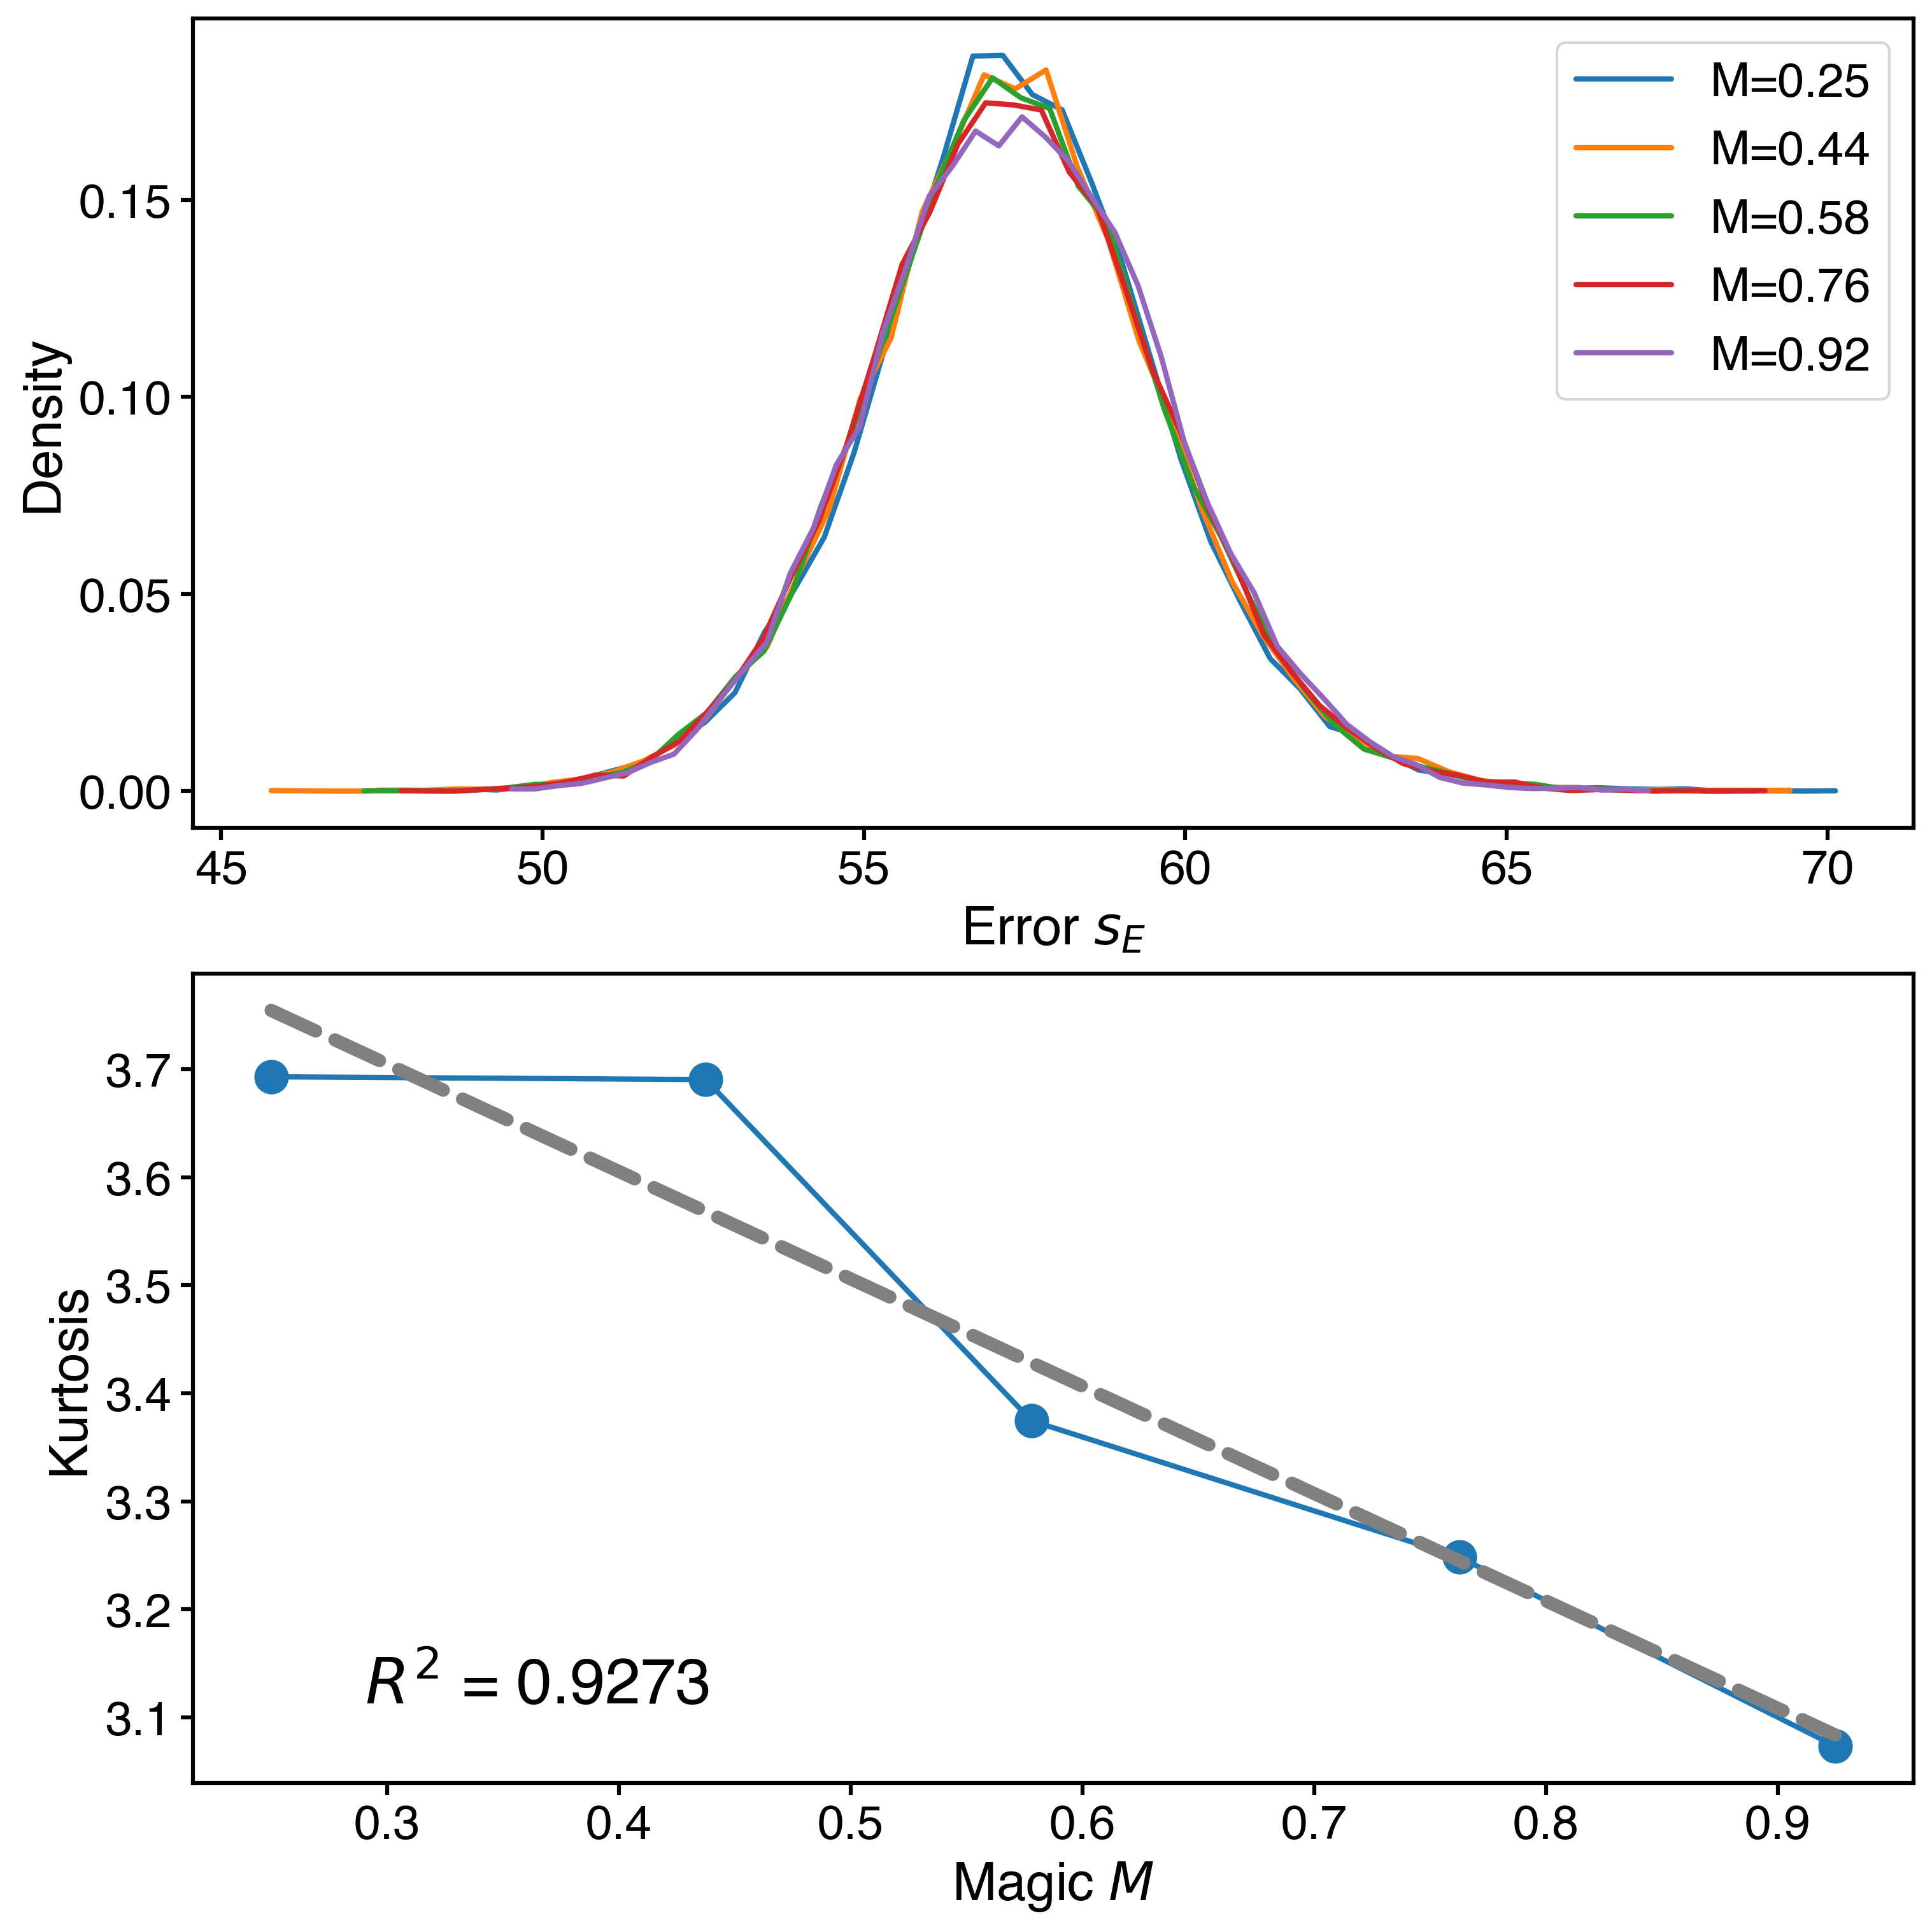

In [12]:
fig, (ax_up, ax_down) = plt.subplots(2,1, figsize=(10,10), layout='constrained')
label_size=20
ax_up.set_xlabel(r"Error $s_E$", fontsize=label_size)
ax_up.set_ylabel(r"Density", fontsize=label_size)
ax_down.set_xlabel(r"Magic $M$", fontsize=label_size)
ax_down.set_ylabel(r"Kurtosis", fontsize=label_size)
ax_up.tick_params(axis='both', which='major', labelsize=label_size-2)
ax_down.tick_params(axis='both', which='major', labelsize=label_size-2)
kurtosis=[]
magics_to_plot=[]
j=0
for i in range(len(Magics)):
    if i in [0,1,2,4,8]:
        S_E=np.power(Update_errors[j],2)/np.power(delta_t,2*order+2)
        hists, bins = np.histogram(S_E, 50, density=True)
        ax_up.plot(bins[:-1], np.power(hists, 1),label=f'M={Magics[i]:.2f}')
        kurtosis.append(np.mean((S_E-np.mean(S_E))**4)/np.var(S_E)**2)
        magics_to_plot.append(Magics[i])
        j+=1
ax_down.plot(magics_to_plot, kurtosis, marker='o')
#Linear fit
z1 = np.polyfit(magics_to_plot, kurtosis, 1)
p1 = np.poly1d(z1)
R_squared = np.corrcoef(kurtosis, p1(magics_to_plot))[0,1]**2
print(f"R-squared for kurtosis fit: {R_squared}")
moments_pre = p1(magics_to_plot)
ax_down.plot(magics_to_plot, moments_pre, "--", color='gray', linewidth=5, label='Linear fit')
plt.text(0.2, 0.12, rf"$R^2$ = {R_squared:.4f}", ha='center', va='center', transform=ax_down.transAxes, fontsize=24)
ax_up.legend()
plt.show()

In [28]:
#Distribution of errors for different entanglement
def random_local(state):
    n=state.num_qubits
    for i in range(n):
        state=state.evolve(random_clifford(1),[i])
    return state
States_of_typical_entanglement=np.load("./vardata/entstates.npy")
States_of_atypical_entanglement=np.load("./vardata/antientstates.npy")
Tyentropies=np.load("vardata/part4typical.npy")
Atyentropies=np.load("vardata/part4atypical.npy")

if(True):
    SampleScale=1
    TypicalErrors=np.load("./OtherHamiltonians/HeisenbergLUtypical.npy").tolist()
    AtypicalErrors=np.load("./OtherHamiltonians/HeisenbergLUatypical.npy").tolist()
    Typical_errors_update=[]
    Atypical_errors_update=[]
    pbar=tqdm(total=len(States_of_typical_entanglement))
    for i,st in enumerate(States_of_typical_entanglement):
        step=0
        state=Statevector(st)
        sample=TypicalErrors[i]
        while step < SampleScale:
            state=random_local(state)
            error=StateError(state.data,Error_U)
            sample.append(error)
            step+=1  
        Typical_errors_update.append(sample)
        pbar.update(1)
    pbar.close()
    print(Typical_errors_update)
    np.save("./OtherHamiltonians/HeisenbergLUtypical.npy",Typical_errors_update)

    pbar=tqdm(total=len(States_of_atypical_entanglement))
    for i,st in enumerate(States_of_atypical_entanglement):
        pbar=tqdm(total=SampleScale)
        step=0
        state=Statevector(st)
        sample=AtypicalErrors[i]
        while step < SampleScale:
            state=random_local(state)
            error=StateError(state.data,Error_U)
            sample.append(error)
            step+=1  
        Atypical_errors_update.append(sample)
        pbar.update(1)
    pbar.close()
    print(Atypical_errors_update)
    np.save("./OtherHamiltonians/HeisenbergLUatypical.npy",Atypical_errors_update)
    

100%|██████████| 41/41 [00:00<00:00, 94.44it/s] 


[[0.07444615415204234, 0.07403558761857043, 0.079968135064636, 0.08926376904829676, np.float64(0.06111788015520881)], [0.0776603627913918, 0.06965753686101853, 0.07050740321560482, 0.07519917522360252, np.float64(0.07034502264696305)], [0.07571095776870365, 0.07672931550739734, 0.07457622091402773, 0.07583231378610866, np.float64(0.07747884586102553)], [0.0758893054697084, 0.0750482971559629, 0.07639162208615567, 0.07424790769887413, np.float64(0.07526144905599591)], [0.07702725943096853, 0.07587243132916506, 0.0763509232918191, 0.07659287032796765, np.float64(0.07550823315490425)], [0.0750259926528634, 0.0762919098468082, 0.0784661392955005, 0.07690986126913933, np.float64(0.07566339635053523)], [0.07728957107850137, 0.07480899492801384, 0.07635198450149747, 0.07664431132092639, np.float64(0.07747309774839929)], [0.07964533361250903, 0.07637031494170161, 0.07574898040711155, 0.07572957490756584, np.float64(0.0776365389397465)], [0.07456821021137075, 0.07656287802803836, 0.074858070970

100%|██████████| 1/1 [00:00<00:00, 163.76it/s]

[[0.08102578558473941, 0.07799024237550237, 0.06620104856691993, 0.06880291209927572, np.float64(0.06517183733481353)], [0.0659395639324153, 0.07592788624114755, 0.08137975000617781, 0.08059949976329829, np.float64(0.07839756002636342)], [0.07627110257069085, 0.07554790595158012, 0.07585951311786335, 0.07250417521839138, np.float64(0.0763599233784752)], [0.07494611912491192, 0.07475890360782572, 0.07353355601980302, 0.07030994863200853, np.float64(0.06890815348695079)], [0.07770537368370362, 0.0760647133302314, 0.07236656800111994, 0.0766048636991164, np.float64(0.07509266537482107)], [0.08299587511719785, 0.07122627410682664, 0.06938692194317406, 0.08049540580042715, np.float64(0.07191583250615761)], [0.07383596403167954, 0.07560659762790925, 0.07429902617361499, 0.0701233567502328, np.float64(0.07647144121251495)], [0.07727723033044698, 0.08313041053835998, 0.07374018909689499, 0.08256819500765478, np.float64(0.07479276324290773)], [0.0754790997524498, 0.07352015669268656, 0.08173804